# AIPI 590 - xAI | Assignment #03

## Explainable Techniques I : Understanding deep learning models with LIME

### Shaila Güereca

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shailajgg/AIPI590_Explainable_AI/blob/main/Explainable_Techniques_I/Explainable_Resnet_lime.ipynb)

## Table of Contents
1. [Introduction](#intro)
2. [Setting Up Our Environment](#setup)
3. [Loading and Preparing Our Model](#model)
4. [Image Preprocessing](#preprocess)
5. [Making Initial Predictions](#predict)
6. [Creating LIME Explanations](#lime)
7. [Visualizing the Results](#viz)
8. [Results](#understanding)

## 1. Introduction <a name="intro"></a>

In this notebook, we'll explore how to make deep learning models more interpretable using LIME (Local Interpretable Model-agnostic Explanations). We'll take a pre-trained ResNet34 model and understand why it makes specific predictions for images.

We will use LIME as a detective that investigates how our model thinks. When we give the model an image, LIME creates slightly different versions of that image and watches how the model's predictions change. This helps us understand which parts of the image are most important for the model's decision.


## 2. Setting Up Our Environment <a name="setup"></a>

First, let's import all the libraries we'll need. 

In [1]:
import torch
from torchvision import (
    models,
    transforms,
)
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

print("All good!")

All good!


## 3. Loading and Preparing Our Model <a name="model"></a>

Now we'll load our pre-trained model. ResNet34 is a convolutional neural network that has been trained on over a million images from ImageNet:

In [2]:
# Load pre-trained ResNet34 model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

print("Model loaded successfully")

Model loaded successfully


## 4. Image Preprocessing <a name="preprocess"></a>

Before we can use an image with our model, we need to preprocess it. This involves several steps that transform our image into the format the model expects:

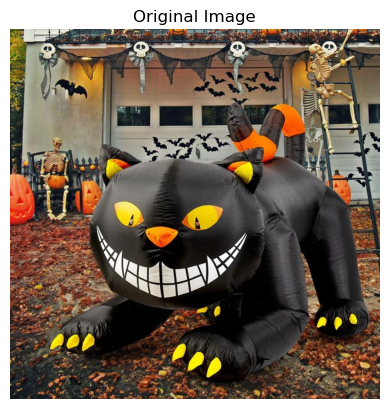

In [3]:
# Define preprocessing pipeline
preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
        transforms.ToTensor(),  # Convert to tensor and scale to [0,1]
        # Normalize using ImageNet statistics
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # Means for each color channel
            std=[0.229, 0.224, 0.225],
        ),
    ]
)  # Standard deviations for each channel ), v

# Load and preprocess image
img_path = "halloween_cat.jpg"
img = Image.open(img_path).convert("RGB")
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Display original image
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

## 5. Making Initial Predictions <a name="predict"></a>

Let's see what our model thinks about this image:

In [4]:
# Load class names
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

# Make prediction
with torch.no_grad():
    output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_idx = probabilities.argmax().item()
    predicted_class = classes[predicted_class_idx]

# Show top 5 predictions
top_5_prob, top_5_idx = torch.topk(probabilities, 5)
print("Top 5 predictions:")
for i in range(5):
    print(f"{classes[top_5_idx[i]]}: {top_5_prob[i]*100:.2f}%")

Top 5 predictions:
jack-o'-lantern: 21.29%
chain saw: 13.00%
toyshop: 7.82%
power drill: 6.63%
comic book: 3.94%



The top prediction of "jack-o'-lantern" with 21.29% probability is very interesting. The strong resemblance to a pumpkin, combined with the Halloween theme and the deceptive image, likely contributed to this prediction.

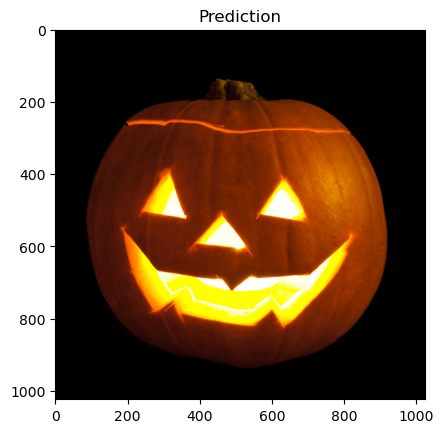

In [5]:
img_path_prediction = "Jack-O-Lantern.jpg"

img2 = Image.open(img_path_prediction).convert("RGB")

# Display Jack-O-Lantern image
plt.imshow(img2)
plt.title("Prediction")
plt.show()

The second prediction, "chain saw" with 13.00% probability, is also interesting.  It suggests that the model might be picking up on the jagged, tooth-like shapes in the image, possibly associating them with the teeth of a chainsaw.  This demonstrates how the model can be influenced by specific visual features, even if they are not directly related to the main object.

These predictions highlight the importance of understanding how deep learning models make decisions.  While they can be very accurate, they can also be influenced by subtle visual cues and contextual factors, leading to unexpected or even incorrect predictions. 

## 6. Creating LIME Explanations <a name="lime"></a>

Now to understand why our model made its decision. We'll define a function that LIME will use to test how our model responds to variations of the input image:

In [6]:
def get_prediction(images):
    """Process a batch of images and return predictions.

    This function does three important things:
    1. Converts numpy arrays to the format our model expects
    2. Applies the same preprocessing we used earlier
    3. Returns probability predictions for all classes
    """
    processed_images = []
    for img_array in images:
        # Convert numpy array to PIL Image
        img_pil = Image.fromarray(img_array.astype("uint8"))
        # Apply our preprocessing
        img_tensor = preprocess(img_pil)
        processed_images.append(img_tensor)

    # Create a batch of images
    batch = torch.stack(processed_images)

    # Get model predictions
    with torch.no_grad():
        output = model(batch)
        probas = torch.nn.functional.softmax(output, dim=1)

    return probas.cpu().numpy()


# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
print("Generating explanation (this may take a few minutes)...")
explanation = explainer.explain_instance(
    np.array(img.resize((224, 224))),
    get_prediction,
    top_labels=5,  # Explain top 5 predictions
    hide_color=0,  # Color used for perturbations
    num_samples=1000,  # Number of perturbations to generate
)
print("Explanation generated!")

Generating explanation (this may take a few minutes)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explanation generated!


## 7. Visualizing the Results <a name="viz"></a>

Let's create a visualization that shows which parts of the image influenced the model's decision:

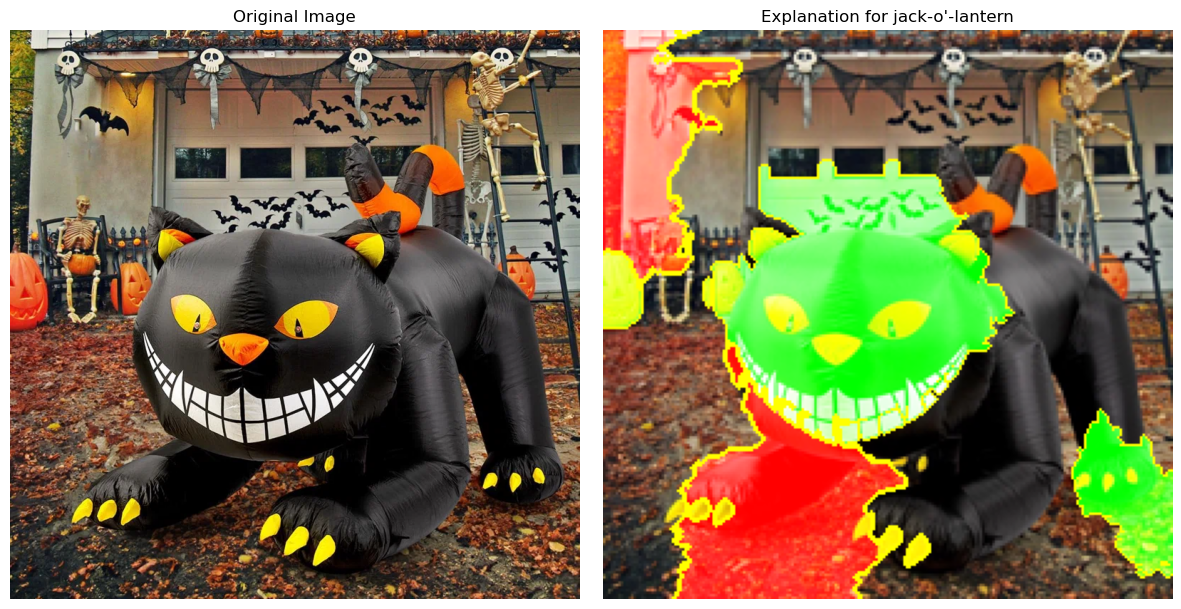

In [7]:
# Get explanation mask for the predicted class
temp, mask = explanation.get_image_and_mask(
    predicted_class_idx,
    positive_only=False,  # Show both positive and negative influences
    num_features=10,  # Number of superpixels to include
    hide_rest=False,  # Show the entire image
)

# Create visualization
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation for {predicted_class}")
plt.axis("off")

plt.tight_layout()
plt.show()

## 8. Results <a name="understanding"></a>

Let's break down what we're seeing in the explanation:

1. **The Highlighted Regions**: 
   - Green areas show parts of the image that supported the model's prediction
   - Red areas show parts that went against the prediction

2. **Superpixels**:
   - The image is divided into meaningful segments called superpixels
   - Each superpixel is tested independently to determine its importance

3. **Interpretation**:
   - Stronger colors indicate stronger influence
   - The model focuses on distinctive features typical of the predicted class

### Limitations to Consider

1. **Computational Cost**: Generating explanations can be slow due to the need for many model predictions.

2. **Stability**: Different runs might produce slightly different explanations due to the random sampling process.

3. **Segmentation Dependence**: The quality of explanations depends on how well the image is segmented into superpixels.

4. **Local vs Global**: LIME provides local explanations only - they might not generalize to other images of the same class.


This tutorial demonstrates the power of LIME for explain deep learning techniques. 

The above code was generated using Claude 3.5 Sonnet on 01/30/25 at 6:13p.m.